In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import logging as lg
lg.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=lg.INFO)
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils 
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

# BROKEN 
* Note sure
* Getting 
```
v5.py:95: RuntimeWarning: overflow encountered in exp
forecast.loc[:,'yhat'] = np.exp(forecast.yhat) - 1
```
* Then breaking on 
```
File "v5.py", line 97, in process_page
    forecast.loc[:,'yhat'] = forecast.yhat.round(0).astype(int)
    ...
 File "/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/pandas/core/dtypes/cast.py", line 620, in astype_nansafe
    raise ValueError('Cannot convert non-finite values (NA or inf) to '
ValueError: Cannot convert non-finite values (NA or inf) to integer
```

# CONCLUSIONs:
* Assuming that the overflow gives inf values
* Need to see which series do it? 
* Need to check
* Or maybe just use big

In [23]:
PROPHET_PATH = '../data/prophet/'
RESULTS_PATH = 'results/'

In [24]:
pagedf = pd.read_feather(PROPHET_PATH+'pagedf.f')
ds = pd.read_feather(PROPHET_PATH+'ds.f')

In [26]:
df = pagedf['93470']

In [12]:
ds.head()

,ds
0,2015-07-01
1,2015-07-02
2,2015-07-03
3,2015-07-04
4,2015-07-05


In [13]:
ds.tail()

,ds
545,2016-12-27
546,2016-12-28
547,2016-12-29
548,2016-12-30
549,2016-12-31


In [17]:
testdf = pd.DataFrame()

In [18]:
testdf

""


In [19]:
testdf['ds'] = pd.date_range('2015-07-01', '2016-12-31')

In [20]:
testdf

,ds
0,2015-07-01
1,2015-07-02
2,2015-07-03
3,2015-07-04
4,2015-07-05
5,2015-07-06
6,2015-07-07
7,2015-07-08
8,2015-07-09
9,2015-07-10


In [6]:
pagedf.head()

,0,1,2,3,4,5,6,7,8,9,...,145053,145054,145055,145056,145057,145058,145059,145060,145061,145062
0,18.0,11.0,1.0,35.0,NaN,12.0,NaN,118.0,5.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.0,14.0,0.0,13.0,NaN,7.0,NaN,26.0,23.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,15.0,1.0,10.0,NaN,4.0,NaN,30.0,14.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13.0,18.0,1.0,94.0,NaN,5.0,NaN,24.0,12.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14.0,11.0,0.0,4.0,NaN,20.0,NaN,29.0,9.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# should break if the dir already exists - avoids accidental overwriting
VERSION = 'v2/'
assert VERSION[-1] == '/'
val_lims = (0,-60)
#os.makedirs(PROPHET_PATH+VERSION)

In [8]:
pagedf = pagedf.fillna(0)

In [8]:
def process_page(page):
    base_log_info = '[Process:{0}, on page:{1}] '.format(mp.current_process().name, page)
    lg.info(base_log_info)
    df_path = PROPHET_PATH+VERSION+page+'df.f'
    model_path = PROPHET_PATH+VERSION+page+'m.pk'
    if os.path.isfile(df_path) and os.path.isfile(model_path):
        lg.info(base_log_info +'df and m EXIST loop')
        forecast = pd.read_feather(df_path)
    else:
        lg.info(base_log_info +'COMPUTE loop')
        df = ds.join(pagedf[page])
        df.columns = ['ds','y']
        # should also consider doing validation on the time period we are forecasting
        traindf = df.iloc[val_lims[0]:val_lims[1]]
        traindf['train'] = 1 # feather won't serialize bool so 1s and 0s...
        lg.info(base_log_info+'Attempt cut outliers')
        traindf.loc[traindf.y > traindf.y.quantile(.95), ['y']] = np.nan
        lg.info(base_log_info+'Finished cut outliers')
        try:
            lg.info(base_log_info+'Attempting fit')
            print(traindf)
            lg.info(traindf)
            m = Prophet(yearly_seasonality=True)
            m.fit(traindf)
            lg.info(base_log_info+'Finished fit')
        except RuntimeError:
            lg.info(base_log_info+'RuntimeError triggered on fit, replacing first y with 0.001 and retry')
            traindf.loc[0,'y'] = 0.001
            m = Prophet(yearly_seasonality=True)
            m.fit(traindf)
        forecast = m.predict(ds)
        forecast['yhat_org'] = forecast['yhat']
        forecast.loc[forecast['yhat'] < 0,['yhat']] = 0.0
        forecast = forecast.join(df.y)
        forecast = forecast.join(traindf.loc[:,['train']]).fillna({'train':0}) # 0 bools
        forecast.to_feather(df_path)
        with open(model_path, 'wb') as file:
            pk.dump(m,file)
        lg.info(base_log_info+'COMPUTE and STORE FINISHED')
    full_smape = wiki.val.smape(forecast.y, forecast.yhat)
    val_smape = wiki.val.smape(forecast[forecast['train'] == 0].y,forecast[forecast['train'] == 0].yhat)
    lg.info(base_log_info +'smape calc finished')
    return (page, full_smape, val_smape)

In [8]:
def process_page2(page):
    base_log_info = '[Process:{0}, on page:{1}] '.format(mp.current_process().name, page)
    lg.info(base_log_info)
    df_path = PROPHET_PATH+VERSION+page+'df.f'
    model_path = PROPHET_PATH+VERSION+page+'m.pk'
    if os.path.isfile(df_path) and os.path.isfile(model_path):
        lg.info(base_log_info +'df and m EXIST loop')
        forecast = pd.read_feather(df_path)
    else:
        lg.info(base_log_info +'COMPUTE loop')
        df = ds.join(pagedf[page])
        df.columns = ['ds','y']
        # should also consider doing validation on the time period we are forecasting
        traindf = df.iloc[val_lims[0]:val_lims[1]]
        traindf['train'] = 1 # feather won't serialize bool so 1s and 0s...
        lg.info(base_log_info+'Attempt cut outliers')
        traindf.loc[traindf.y > traindf.y.quantile(.95), ['y']] = np.nan
        lg.info(base_log_info+'Finished cut outliers')
        lg.info(base_log_info+'Attempting fit')
        print(traindf)
        lg.info(traindf)
        m = Prophet(yearly_seasonality=True)
        m.fit(traindf)
        lg.info(base_log_info+'Finished fit')
        forecast = m.predict(ds)
        forecast['yhat_org'] = forecast['yhat']
        forecast.loc[forecast['yhat'] < 0,['yhat']] = 0.0
        forecast = forecast.join(df.y)
        forecast = forecast.join(traindf.loc[:,['train']]).fillna({'train':0}) # 0 bools
        forecast.to_feather(df_path)
        with open(model_path, 'wb') as file:
            pk.dump(m,file)
        lg.info(base_log_info+'COMPUTE and STORE FINISHED')
    full_smape = wiki.val.smape(forecast.y, forecast.yhat)
    val_smape = wiki.val.smape(forecast[forecast['train'] == 0].y,forecast[forecast['train'] == 0].yhat)
    lg.info(base_log_info +'smape calc finished')
    return (page, full_smape, val_smape)

In [28]:
pagedf['93470'].head()

0     96.0
1     99.0
2    145.0
3     61.0
4     58.0
Name: 93470, dtype: float64

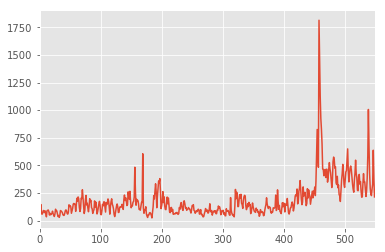

In [29]:
pagedf['93470'].plot()

In [30]:
df = ds.join(pagedf['93470'])
df.columns = ['ds','y']

In [31]:
df.head()

,ds,y
0,2015-07-01,96.0
1,2015-07-02,99.0
2,2015-07-03,145.0
3,2015-07-04,61.0
4,2015-07-05,58.0


In [33]:
df.loc[0,'y'] = 67;df.head()

,ds,y
0,2015-07-01,67.0
1,2015-07-02,99.0
2,2015-07-03,145.0
3,2015-07-04,61.0
4,2015-07-05,58.0


In [13]:
traindf = df.iloc[val_lims[0]:val_lims[1]]
traindf['train'] = 1 # feather won't serialize bool so 1s and 0s...
traindf.loc[traindf.y > traindf.y.quantile(.95), ['y']] = np.nan

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
traindf.head()

,ds,y,train
0,2015-07-01,96.0,1
1,2015-07-02,99.0,1
2,2015-07-03,145.0,1
3,2015-07-04,61.0,1
4,2015-07-05,58.0,1


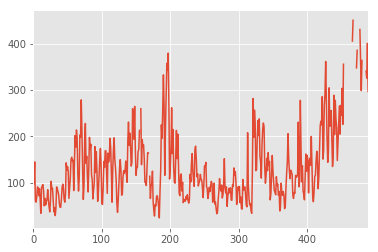

In [15]:
traindf.y.plot()

In [17]:
print(traindf.y.values)

[  96.   99.  145.   61.   58.   69.   91.   89.   72.   87.   64.   34.
   89.   93.   96.   82.   50.   66.   52.   59.   64.   85.   63.   48.
   37.   60.  103.   86.   88.   64.   37.   46.   29.   45.   91.   87.
   80.   74.   55.   47.   47.   64.   89.   97.   88.   64.   58.   75.
  143.  127.  135.  124.   66.   89.  110.  149.  155.  147.  149.   83.
  147.  202.  177.  214.  197.  119.   82.  108.  203.  198.  279.  211.
  130.   64.   93.  191.  228.  142.  157.  113.   80.  130.  198.  173.
  183.  117.  107.   65.   84.   99.  178.  122.  167.  120.   60.   80.
  117.  150.  174.  137.   56.   53.   89.  146.  133.  169.  169.  122.
   77.  164.  145.  157.  196.  175.  122.   58.  129.  170.  197.  150.
  132.  106.   56.   36.   63.   96.  133.  150.  125.   73.   75.  113.
  126.  120.  126.  147.  118.  101.  190.  231.  181.  207.  177.  136.
  144.  260.  223.  194.  265.  174.  116.  133.  133.  167.  172.  213.
   nan  260.  139.  193.  178.  182.  153.  101.  1

In [24]:
print('[',end='')
for val in traindf.y.values:
    print(str(val)+', ', end='')

[96.0, 99.0, 145.0, 61.0, 58.0, 69.0, 91.0, 89.0, 72.0, 87.0, 64.0, 34.0, 89.0, 93.0, 96.0, 82.0, 50.0, 66.0, 52.0, 59.0, 64.0, 85.0, 63.0, 48.0, 37.0, 60.0, 103.0, 86.0, 88.0, 64.0, 37.0, 46.0, 29.0, 45.0, 91.0, 87.0, 80.0, 74.0, 55.0, 47.0, 47.0, 64.0, 89.0, 97.0, 88.0, 64.0, 58.0, 75.0, 143.0, 127.0, 135.0, 124.0, 66.0, 89.0, 110.0, 149.0, 155.0, 147.0, 149.0, 83.0, 147.0, 202.0, 177.0, 214.0, 197.0, 119.0, 82.0, 108.0, 203.0, 198.0, 279.0, 211.0, 130.0, 64.0, 93.0, 191.0, 228.0, 142.0, 157.0, 113.0, 80.0, 130.0, 198.0, 173.0, 183.0, 117.0, 107.0, 65.0, 84.0, 99.0, 178.0, 122.0, 167.0, 120.0, 60.0, 80.0, 117.0, 150.0, 174.0, 137.0, 56.0, 53.0, 89.0, 146.0, 133.0, 169.0, 169.0, 122.0, 77.0, 164.0, 145.0, 157.0, 196.0, 175.0, 122.0, 58.0, 129.0, 170.0, 197.0, 150.0, 132.0, 106.0, 56.0, 36.0, 63.0, 96.0, 133.0, 150.0, 125.0, 73.0, 75.0, 113.0, 126.0, 120.0, 126.0, 147.0, 118.0, 101.0, 190.0, 231.0, 181.0, 207.0, 177.0, 136.0, 144.0, 260.0, 223.0, 194.0, 265.0, 174.0, 116.0, 133.0, 133.

In [25]:
traindf.loc[0,'y'] = 96

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
print('[',end='')
i = 0
for val in traindf.y.values:
    if i>9:
        print(str(val)+', ',end='\\\n')
        i = 0
    else:
        print(str(val)+', ',end='')
    i += 1

[96.0, 99.0, 145.0, 61.0, 58.0, 69.0, 91.0, 89.0, 72.0, 87.0, 64.0, \
34.0, 89.0, 93.0, 96.0, 82.0, 50.0, 66.0, 52.0, 59.0, 64.0, \
85.0, 63.0, 48.0, 37.0, 60.0, 103.0, 86.0, 88.0, 64.0, 37.0, \
46.0, 29.0, 45.0, 91.0, 87.0, 80.0, 74.0, 55.0, 47.0, 47.0, \
64.0, 89.0, 97.0, 88.0, 64.0, 58.0, 75.0, 143.0, 127.0, 135.0, \
124.0, 66.0, 89.0, 110.0, 149.0, 155.0, 147.0, 149.0, 83.0, 147.0, \
202.0, 177.0, 214.0, 197.0, 119.0, 82.0, 108.0, 203.0, 198.0, 279.0, \
211.0, 130.0, 64.0, 93.0, 191.0, 228.0, 142.0, 157.0, 113.0, 80.0, \
130.0, 198.0, 173.0, 183.0, 117.0, 107.0, 65.0, 84.0, 99.0, 178.0, \
122.0, 167.0, 120.0, 60.0, 80.0, 117.0, 150.0, 174.0, 137.0, 56.0, \
53.0, 89.0, 146.0, 133.0, 169.0, 169.0, 122.0, 77.0, 164.0, 145.0, \
157.0, 196.0, 175.0, 122.0, 58.0, 129.0, 170.0, 197.0, 150.0, 132.0, \
106.0, 56.0, 36.0, 63.0, 96.0, 133.0, 150.0, 125.0, 73.0, 75.0, \
113.0, 126.0, 120.0, 126.0, 147.0, 118.0, 101.0, 190.0, 231.0, 181.0, \
207.0, 177.0, 136.0, 144.0, 260.0, 223.0, 194.0, 265.

In [55]:
nan = np.nan
y = [96.0, 99.0, 145.0, 61.0, 58.0, 69.0, 91.0, 89.0, 72.0, 87.0, 64.0, \
34.0, 89.0, 93.0, 96.0, 82.0, 50.0, 66.0, 52.0, 59.0, 64.0, \
85.0, 63.0, 48.0, 37.0, 60.0, 103.0, 86.0, 88.0, 64.0, 37.0, \
46.0, 29.0, 45.0, 91.0, 87.0, 80.0, 74.0, 55.0, 47.0, 47.0, \
64.0, 89.0, 97.0, 88.0, 64.0, 58.0, 75.0, 143.0, 127.0, 135.0, \
124.0, 66.0, 89.0, 110.0, 149.0, 155.0, 147.0, 149.0, 83.0, 147.0, \
202.0, 177.0, 214.0, 197.0, 119.0, 82.0, 108.0, 203.0, 198.0, 279.0, \
211.0, 130.0, 64.0, 93.0, 191.0, 228.0, 142.0, 157.0, 113.0, 80.0, \
130.0, 198.0, 173.0, 183.0, 117.0, 107.0, 65.0, 84.0, 99.0, 178.0, \
122.0, 167.0, 120.0, 60.0, 80.0, 117.0, 150.0, 174.0, 137.0, 56.0, \
53.0, 89.0, 146.0, 133.0, 169.0, 169.0, 122.0, 77.0, 164.0, 145.0, \
157.0, 196.0, 175.0, 122.0, 58.0, 129.0, 170.0, 197.0, 150.0, 132.0, \
106.0, 56.0, 36.0, 63.0, 96.0, 133.0, 150.0, 125.0, 73.0, 75.0, \
113.0, 126.0, 120.0, 126.0, 147.0, 118.0, 101.0, 190.0, 231.0, 181.0, \
207.0, 177.0, 136.0, 144.0, 260.0, 223.0, 194.0, 265.0, 174.0, 116.0, \
133.0, 133.0, 167.0, 172.0, 213.0, nan, 260.0, 139.0, 193.0, 178.0, \
182.0, 153.0, 101.0, 101.0, 94.0, 132.0, 165.0, 164.0, nan, 114.0, \
66.0, 93.0, 98.0, 125.0, 59.0, 40.0, 28.0, 53.0, 50.0, 70.0, \
72.0, 63.0, 49.0, 24.0, 79.0, 125.0, 225.0, 196.0, 259.0, 333.0, \
265.0, 116.0, 217.0, 288.0, 358.0, 344.0, 380.0, 268.0, 108.0, 135.0, \
174.0, 262.0, 163.0, 215.0, 134.0, 101.0, 99.0, 152.0, 213.0, 152.0, \
205.0, 141.0, 77.0, 72.0, 116.0, 119.0, 82.0, 101.0, 57.0, 64.0, \
61.0, 60.0, 70.0, 65.0, 74.0, 61.0, 56.0, 64.0, 118.0, 102.0, \
143.0, 163.0, 124.0, 105.0, 92.0, 172.0, 179.0, 152.0, 113.0, 119.0, \
93.0, 100.0, 104.0, 118.0, 107.0, 106.0, 89.0, 68.0, 94.0, 136.0, \
134.0, 144.0, 92.0, 87.0, 66.0, 76.0, 90.0, 81.0, 94.0, 103.0, \
97.0, 58.0, 71.0, 99.0, 54.0, 58.0, 44.0, 33.0, 37.0, 63.0, \
81.0, 109.0, 90.0, 82.0, 95.0, 67.0, 74.0, 99.0, 152.0, 89.0, \
78.0, 91.0, 49.0, 71.0, 80.0, 88.0, 78.0, 89.0, 63.0, 62.0, \
96.0, 92.0, 132.0, 116.0, 124.0, 100.0, 53.0, 66.0, 91.0, 85.0, \
92.0, 57.0, 69.0, 44.0, 43.0, 107.0, 84.0, 89.0, 91.0, 74.0, \
52.0, 48.0, 208.0, 94.0, 67.0, 52.0, 55.0, 39.0, 34.0, 130.0, \
282.0, 198.0, 257.0, 230.0, 126.0, 128.0, 190.0, 234.0, 202.0, 238.0, \
157.0, 144.0, 110.0, 183.0, 216.0, 229.0, 221.0, 134.0, 99.0, 116.0, \
153.0, 126.0, 165.0, 137.0, 146.0, 63.0, 77.0, 117.0, 159.0, 125.0, \
101.0, 83.0, 79.0, 74.0, 113.0, 94.0, 97.0, 73.0, 81.0, 39.0, \
48.0, 99.0, 75.0, 73.0, 81.0, 73.0, 44.0, 48.0, 90.0, 121.0, \
145.0, 206.0, 152.0, 125.0, 109.0, 127.0, 123.0, 118.0, 74.0, 66.0, \
79.0, 77.0, 116.0, 112.0, 113.0, 119.0, 231.0, 91.0, 103.0, 278.0, \
172.0, 102.0, 137.0, 83.0, 75.0, 63.0, 115.0, 162.0, 125.0, 159.0, \
149.0, 78.0, 145.0, 153.0, 138.0, 200.0, 138.0, 72.0, 59.0, 79.0, \
114.0, 116.0, 147.0, 168.0, 145.0, 87.0, 113.0, 166.0, 223.0, 233.0, \
225.0, 286.0, 151.0, 169.0, 266.0, 292.0, 362.0, 279.0, 195.0, 144.0, \
166.0, 305.0, 222.0, 235.0, 256.0, 193.0, 135.0, 155.0, 289.0, 204.0, \
278.0, 239.0, 218.0, 148.0, 187.0, 226.0, 266.0, 205.0, 267.0, 246.0, \
304.0, 226.0, 356.0, nan, nan, nan, nan, nan, nan, nan, \
nan, nan, nan, nan, nan, 406.0, 451.0, nan, 390.0, nan, \
nan, 348.0, 386.0, nan, nan, nan, 431.0, 363.0, 299.0, 364.0, \
nan, nan, nan, nan, nan, 341.0, 326.0, 401.0, 297.0]

In [56]:
traindf.y = y

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [57]:
traindf.head()

,ds,y,train
0,2015-07-01,96.0,1
1,2015-07-02,99.0,1
2,2015-07-03,145.0,1
3,2015-07-04,61.0,1
4,2015-07-05,58.0,1


In [ ]:
m = Prophet(yearly_seasonality=True)
m.fit(traindf)

In [24]:
forecast = m.predict(ds)

In [28]:
forecast['yhat_org'] = forecast['yhat']
forecast.loc[forecast['yhat'] < 0,['yhat']] = 0.0
forecast = forecast.join(df.y)
forecast = forecast.join(traindf.loc[:,['train']]).fillna({'train':0}) # 0 bools

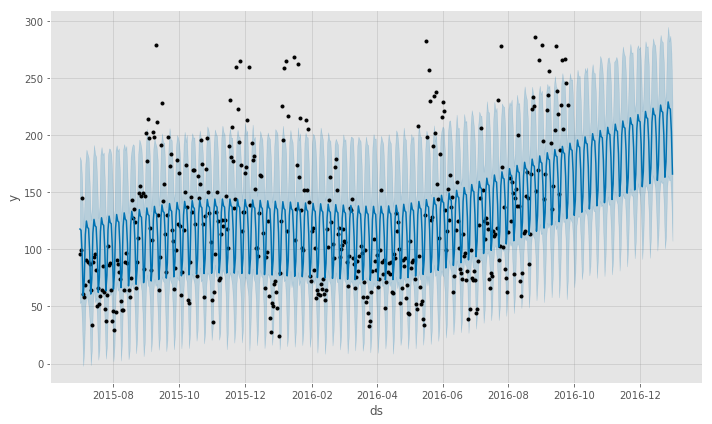

In [26]:
m.plot(forecast);

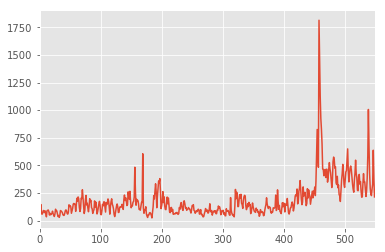

In [30]:
pagedf['93470'].plot()

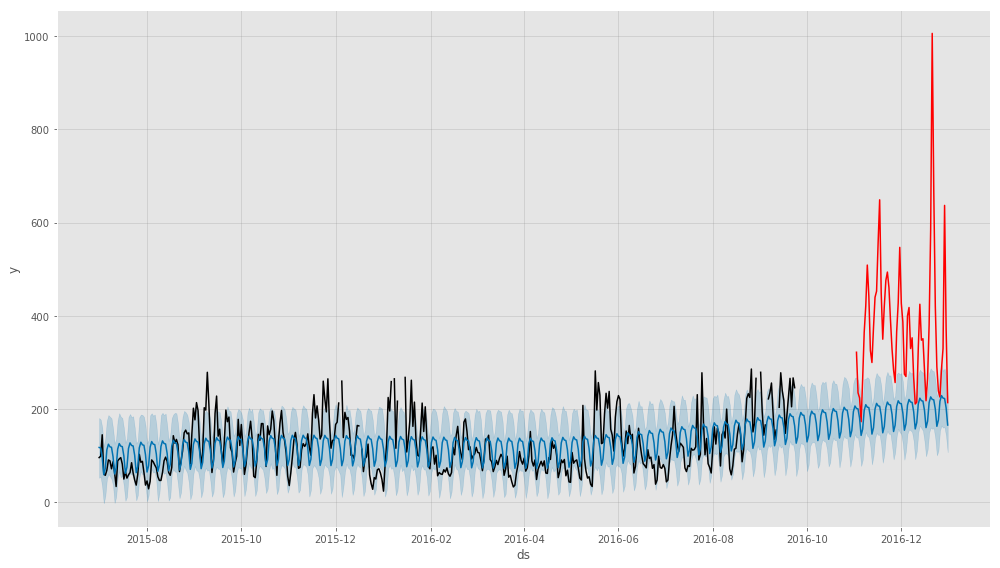

In [29]:
wiki.newphet.prophet_plot(forecast)

In [ ]:
process_page2('93470')

2017-08-28 23:32:48,045 : INFO : [Process:MainProcess, on page:93470] 
2017-08-28 23:32:48,046 : INFO : [Process:MainProcess, on page:93470] COMPUTE loop
/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
2017-08-28 23:32:48,079 : INFO : [Process:MainProcess, on page:93470] Attempt cut outliers
/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v